# MLP as Universal Approximator

- **Universal Approximation theorem**
    - A multi-layer perceptron can be used to approximate any function.

## Activation Functions

### Sigmoid

$$
\text{Sigmoid}(x) = \sigma(x) = \frac{1}{1 + \exp(-x)}
$$

### ReLU

- The Rectified Linear Unit function

$$
\text{ReLU}(x) = (x)^+ = \max(0, x)
$$

### Tanh

- Hyperbolic Tangent

$$
\text{Tanh}(x) = \tanh(x) = \frac{\exp(x) - \exp(-x)} {\exp(x) + \exp(-x)}
$$

## Experiments

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchsummary import summary

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU detected, using CPU")

cpu_device = torch.device("cpu")

GPU detected: NVIDIA T400 4GB


### Objective Functions

In [3]:
def func_c(x):
    return torch.sin(x ** 2 + 3) + torch.cos(2 * x ** 3 + 3 * x ** 2 + 2)


def func_b(x):
    return torch.sin(x ** 2 + 3)


def func_a(x):
    return 5 * x ** 2 + 3

func_range = (-1, 1)
objective_func = lambda x, device: func_c(x) + torch.normal(0, 0.01, x.shape).to(device)

## Function Fitting

In [4]:
def my_train(model, input_size, target_func, func_range, device, learning_rate=0.001):
    loss_fn = nn.MSELoss()
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 10000
    batch_size = 128

    model.train()
    model.to(device)
    a = func_range[0]
    b = func_range[1]

    for epoch in tqdm(range(num_epochs), dynamic_ncols=True, desc=f'Training on {device}'):
        optimizer.zero_grad()

        xx = a + (b - a) * torch.rand(batch_size, input_size)
        xx = xx.to(device)
        y_pred = model(xx)
        y = objective_func(xx, device)
        loss = loss_fn(y_pred, y)

        loss.backward()
        optimizer.step()
    print(f"Loss value: {loss.item()}")

In [5]:
def xavier_init(model):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            init.xavier_normal_(layer.weight)

In [6]:
input_size = 1
hidden_size = 1024
output_size = 1

## Shallow Network

In [7]:
shallow_network = torch.nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)
shallow_network.to(device)
shallow_network.apply(xavier_init)

summary(shallow_network, input_size=(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]           2,048
              ReLU-2                 [-1, 1024]               0
            Linear-3                    [-1, 1]           1,025
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [8]:
my_train(shallow_network, input_size, objective_func, func_range, device)
print('done.')

Training on cuda:0:   0%|          | 0/10000 [00:00<?, ?it/s]

Loss value: 0.007621679455041885
done.


### Visualization

In [9]:
def plot_function_fit(obj_func, models, func_range, device):
    """
    plot the function fitting result
    :param obj_func: Objection Function
    :param models: NN Model
    :param func_range: function range
    :param device: GPU or CPU
    """

    data_x = torch.linspace(func_range[0], func_range[1], 100).unsqueeze(1)
    data_y = obj_func(data_x, cpu_device)

    pred_x = torch.linspace(func_range[0], func_range[1], 200).unsqueeze(1)

    plt.figure(figsize=(8, 8))
    plt.scatter(data_x, data_y, label="Data", c='yellow')

    for model in models:
        pred_y = model(pred_x.to(device))
        plt.plot(pred_x, pred_y.detach().cpu().numpy(), label=type(model).__name__)

    plt.grid()
    plt.legend()
    plt.show()


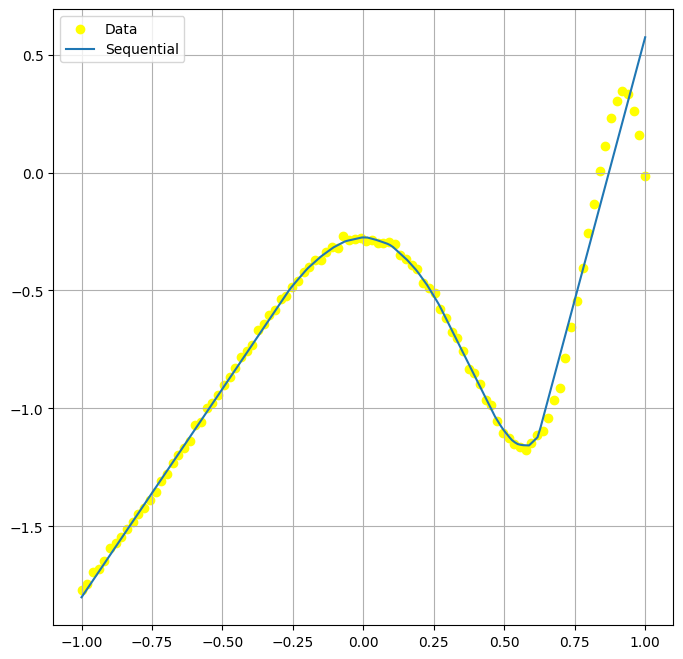

In [10]:
shallow_network.eval()
plot_function_fit(objective_func, [shallow_network], func_range, device)

## MLP


In [11]:
class MyMLP(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_size, output_size):
        super(MyMLP, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])

        # Output layer
        self.layers.append(nn.Linear(hidden_size, output_size))

        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)


In [12]:
mlp = MyMLP(input_size, 8, 16, output_size)
mlp.apply(xavier_init)
mlp.to(device)

summary(mlp, input_size=(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]              32
              ReLU-2                   [-1, 16]               0
            Linear-3                   [-1, 16]             272
              ReLU-4                   [-1, 16]               0
            Linear-5                   [-1, 16]             272
              ReLU-6                   [-1, 16]               0
            Linear-7                   [-1, 16]             272
              ReLU-8                   [-1, 16]               0
            Linear-9                   [-1, 16]             272
             ReLU-10                   [-1, 16]               0
           Linear-11                   [-1, 16]             272
             ReLU-12                   [-1, 16]               0
           Linear-13                   [-1, 16]             272
             ReLU-14                   

In [13]:
my_train(mlp, input_size, objective_func, func_range, device)

Training on cuda:0:   0%|          | 0/10000 [00:00<?, ?it/s]

Loss value: 0.00036084422026760876


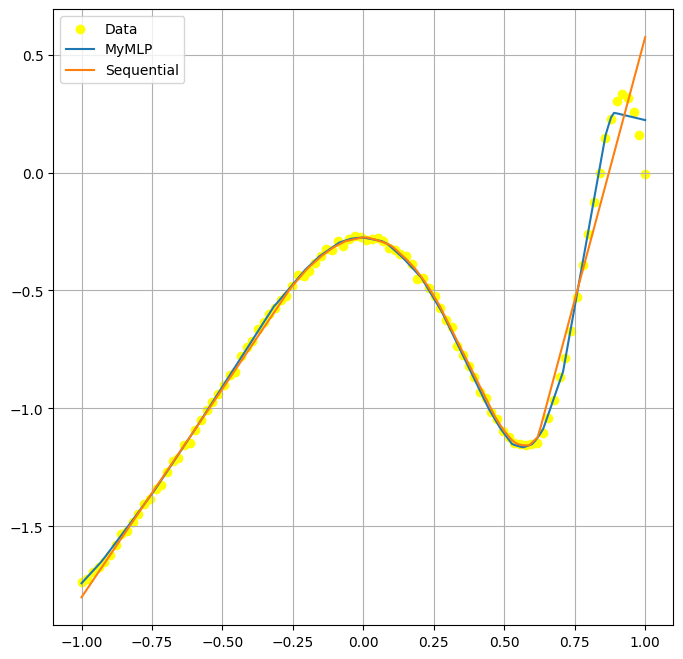

In [14]:
mlp.eval()
plot_function_fit(objective_func, [mlp, shallow_network], func_range, device)

## High Dimension Functions

In [15]:
input_size = 16
output_size = 16

func_range_m = [
    torch.ones(input_size)*-1,
    torch.ones(input_size)
]


In [16]:
mlp = MyMLP(input_size, 8, 256, output_size)
mlp.apply(xavier_init)
my_train(mlp, input_size, objective_func, func_range_m, device, 1e-4)

Training on cuda:0:   0%|          | 0/10000 [00:00<?, ?it/s]

Loss value: 0.009449731558561325


In [17]:
shallow_network = torch.nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)
shallow_network.apply(xavier_init)

my_train(shallow_network, input_size, objective_func, func_range, device)

Training on cuda:0:   0%|          | 0/10000 [00:00<?, ?it/s]

Loss value: 0.004353749565780163
